# GPSat Along-Track Interpolation
Materials can be accessed [here](https://drive.google.com/drive/folders/14iRZmclnRpIzdvK3y1BBuD-_nnwOIpTX?usp=sharing).

The main objective of this notebook is to:

- Extract **along-track observations** from GPOD processed data, including elevation, classification (lead/floe), and interpolated sea level anomaly (SLA).
- Apply **GPSat's along-track interpolation** to estimate SLA at all observation points (leads and floes).
- Compare GPSat's interpolated SLA against the **linear interpolation**.
- Visualiae and assess the differences in interpolated SLA along specific satellite tracks, particularly over leads and floes.
- The comparison helps evaluate the benefit of spatio-temporal interpolation using Gaussian Processes (GPSat) versus simple linear interpolation.


## Import GPSat

In [1]:
! pip install cartopy

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

fatal: destination path 'GPSat' already exists and is not an empty directory.
changing directory to: /content/GPSat


In [3]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 require

In [4]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Attempting uninstall: GPSat
    Found existing installation: GPSat 0.0.0
    Uninstalling GPSat-0.0.0:
      Successfully uninstalled GPSat-0.0.0
  Running setup.py develop for GPSat


In [5]:
import os
import re
import glob
import numpy as np
import pandas as pd
import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from datetime import datetime, timedelta
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.postprocessing import smooth_hyperparameters
import GPSat
from GPSat.postprocessing import glue_local_predictions_1d
from GPSat.postprocessing import glue_local_predictions_2d


def GCdist(X,Xs):
    radius = lambda lat : np.sqrt(((6378137**2 * np.cos(lat))**2 + (6356752**2 * np.sin(lat))**2/\
                                  (6378137 * np.cos(lat))**2 + (6356752 * np.sin(lat))**2))

    minlat = min(np.min(X.T[(1,)].T),np.min(Xs.T[(1,)].T))
    maxlat = max(np.max(X.T[(1,)].T),np.max(Xs.T[(1,)].T))
    lon1 = np.radians(X.T[(0,)].T) ; lat1 = np.radians(X.T[(1,)].T)
    lon2 = np.radians(Xs.T[(0,)].T) ; lat2 = np.radians(Xs.T[(1,)].T)
    r = 6356752#np.mean(radius(np.arange(minlat,maxlat)))

    Clat1 = np.cos(lat1) ; Clat2 = np.cos(lat2)
    Slat1 = np.sin(lat1) ; Slat2 = np.sin(lat2)
    Clon1 = np.cos(lon1) ; Clon2 = np.cos(lon2)
    Slon1 = np.sin(lon1) ; Slon2 = np.sin(lon2)

    n1 = np.array([Clat1*Clon1,Clat1*Slon1,Slat1]).T
    n2 = np.array([Clat2*Clon2,Clat2*Slon2,Slat2]).T
    return r*np.arccos(np.dot(n1,n2.T))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [9]:
#indices for GPOD data:
#0 = Lon
#1 = Lat
#2 = Interpolated SLA
#3 = Error in interpolated SLA
#4 = Freeboard
#5 = Pulse Peakiness
#6 = Lew
#7 = Class (1=Lead, 2=Floe, 3=OO)
#8 = Sigma 0
#9 = Raw Elevation
#10 = Mean Sea-surface
#11 = SIC
#12 = Sea ice type (0=FYI, 1=MYI)
#13 = Snow depth
#14 = Snow density
#15 = Sea ice thickness
#16 = GPOD SLA
#17 = GPOD SSH
#18 = GPOD SWH
#19 = Elevation from Samosa

def process_track(track, grab_dates, satellite, count):
    """ Process a single track file if it falls on a date of interest """
    date = track.split('/')[-1].split('T')[0].split('_')[-1]
    if date in grab_dates:
        time = 14975 + (datetime.strptime(date, '%Y%m%d') - datetime(2011, 1, 1)).days
        f = np.genfromtxt(track)

        ID = np.where((f[:, 7] < 3) & (f[:, 11] >= 0.75))[0]
        classes = np.where(f[ID, 7] == 1.0, 'lead', 'floe')

        elvmss = f[ID, 9] - f[ID, 10]
        elvmss[classes == 'floe'] -= 0.1626  # Apply bias correction (see Lawrence et al., 2019)

        xg, yg = WGS84toEASE2_New(f[ID, 0], f[ID, 1])
        N = len(xg)

        # Initialise dataframe to store retrieved track data
        track_df = pd.DataFrame()

        track_df['x']= xg
        track_df['y'] = yg
        track_df['t'] = [time] * N
        track_df['lon'] = f[ID, 0]
        track_df['lat'] = f[ID, 1]
        track_df['date'] = [date] * N
        track_df['class'] = classes
        track_df['interpSLA'] = f[ID, 2]
        track_df['elevation'] = elvmss
        track_df['SAT'] = [satellite] * N
        track_df['track'] = [count] * N
        return count + 1, track_df

    return count, None

# Generate date range
interp_date = datetime(2019, 1, 15)
grab_dates = [(interp_date - timedelta(days=x)).strftime('%Y%m%d') for x in range(5)] + \
             [(interp_date + timedelta(days=x)).strftime('%Y%m%d') for x in range(1, 5)]

# Path to directories
# dirs = sorted(glob.glob('/Users/wg4031/Dropbox/GPOD_DATA/*'))
# dirs = sorted(glob.glob('/content/drive/MyDrive/AI4EO/Week 8/GPOD/*'))
dirs = sorted(glob.glob('/content/drive/MyDrive/GEOL0069/Week 8/GPOD/*'))

# Process tracks
track_dfs = []
count = 0
for directory in dirs:
    satellite = directory.split('/')[-1]
    if satellite in {'SARIN', 'SAR'}:
        satellite = 'CS2'
    for track in sorted(glob.glob(f"{directory}/*v1.proc")):
        count, track_df = process_track(track, grab_dates, satellite, count)
        if track_df is not None:
            track_dfs.append(track_df)

#Create a single dataframe for all tracks
df = pd.concat(track_dfs, ignore_index=True)
df

<ipython-input-9-1d6d74572eb9>:36: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  xg, yg = WGS84toEASE2_New(f[ID, 0], f[ID, 1])
<ipython-input-9-1d6d74572eb9>:36: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  xg, yg = WGS84toEASE2_New(f[ID, 0], f[ID, 1])
<ipython-input-9-1d6d74572eb9>:36: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  xg, yg = WGS84toEASE2_New(f[ID, 0], f[ID, 1])
<ipython-input-9-1d6d74572eb9>:36: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  xg, yg = WGS84toEASE2_New(f[ID, 0], f[ID, 1])
<ipython-inp

,x,y,t,lon,lat,date,class,interpSLA,elevation,SAT,track
0,-3.056178e+06,-1.270463e+06,17907,-67.427184,60.000844,20190111,lead,NaN,0.4397,S3A,0
1,-3.055943e+06,-1.270243e+06,17907,-67.429148,60.003653,20190111,lead,0.4207,0.4250,S3A,0
2,-3.055707e+06,-1.270022e+06,17907,-67.431112,60.006463,20190111,lead,0.4201,0.4296,S3A,0
3,-3.055472e+06,-1.269801e+06,17907,-67.433077,60.009272,20190111,lead,0.4195,0.4494,S3A,0
4,-3.055236e+06,-1.269580e+06,17907,-67.435042,60.012081,20190111,lead,0.4190,0.4171,S3A,0
...,...,...,...,...,...,...,...,...,...,...,...
414747,-6.343986e+05,-4.106771e+05,17909,-57.083051,83.229731,20190113,floe,NaN,0.0195,CS2,152
414748,-6.346926e+05,-4.107562e+05,17909,-57.090123,83.227131,20190113,floe,NaN,NaN,CS2,152
414749,-6.349865e+05,-4.108354e+05,17909,-57.097191,83.224532,20190113,floe,NaN,0.3082,CS2,152
414750,-6.352805e+05,-4.109145e+05,17909,-57.104252,83.221933,20190113,floe,NaN,0.1651,CS2,152


In [10]:
import pandas as pd

savepath = '/content/drive/MyDrive/GEOL0069/Week 8/'
df.to_csv(savepath+'df_GPOD.csv', index=False)

In [11]:
import pandas as pd

savepath = '/content/drive/MyDrive/GEOL0069/Week 8/'
df = pd.read_csv(savepath+'df_GPOD.csv')

# Select profile for interpolation

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


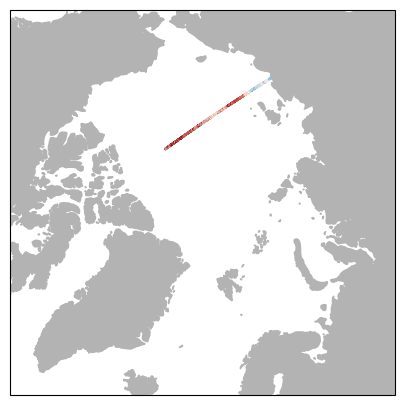

,x,y,t,lon,lat,date,class,interpSLA,elevation,SAT,track
3051,-546016.208513,7.870765e+05,17907,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1
3052,-545744.788692,7.872712e+05,17907,-145.269889,81.414930,20190111,floe,NaN,0.1204,S3A,1
3053,-545473.353742,7.874660e+05,17907,-145.289868,81.414880,20190111,floe,NaN,0.2833,S3A,1
3054,-545201.932777,7.876608e+05,17907,-145.309847,81.414830,20190111,floe,NaN,0.2403,S3A,1
3055,-544930.498775,7.878555e+05,17907,-145.329826,81.414779,20190111,floe,NaN,0.1529,S3A,1
...,...,...,...,...,...,...,...,...,...,...,...
6054,985661.345909,1.804912e+06,17907,151.361068,71.501454,20190111,lead,-0.0670,-0.1594,S3A,1
6055,985942.928513,1.805084e+06,17907,151.356490,71.498852,20190111,lead,-0.0672,-0.1119,S3A,1
6056,986224.515088,1.805257e+06,17907,151.351913,71.496250,20190111,lead,-0.0674,-0.0875,S3A,1
6057,986506.099320,1.805430e+06,17907,151.347337,71.493648,20190111,lead,-0.0677,-0.1143,S3A,1


In [12]:
interptrack = 1 #select the 2nd track loaded within the specified date range around our interp date
df_val = df.loc[df['track']==interptrack]


fig,ax = plt.subplots(1,figsize=(5,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())
ax.add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
ax.scatter(df_val['lon'],df_val['lat'],s=0.5,c=df_val['elevation'],cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
plt.show()

df_val

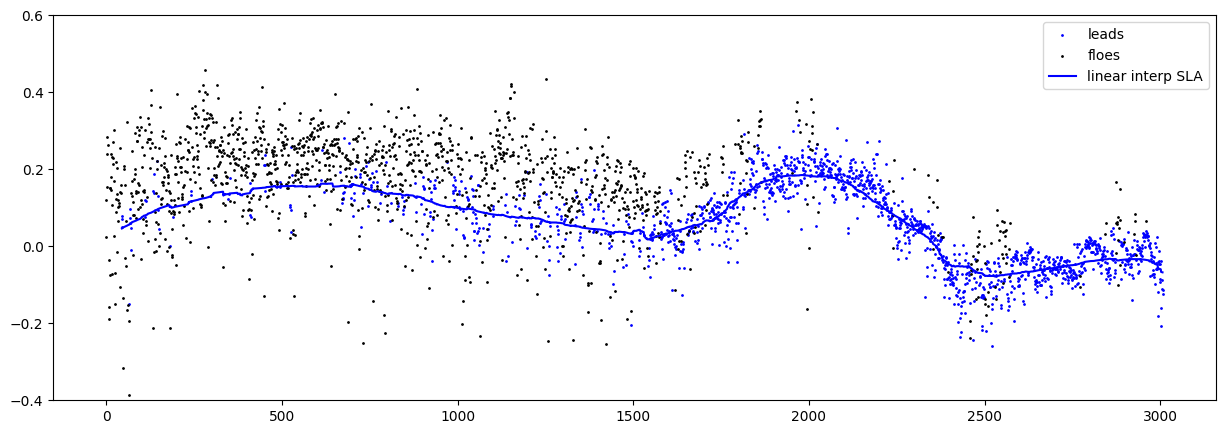

In [13]:
leads = np.where(df_val['class'] == 'lead')
floes = np.where(df_val['class'] == 'floe')
fig,ax = plt.subplots(1,figsize=(15,5))
ax.scatter(leads,df_val['elevation'].iloc[leads],color='b',s=1,label='leads')
ax.scatter(floes,df_val['elevation'].iloc[floes],color='k',s=1,label='floes')
ax.plot(np.arange(len(df_val['interpSLA'])),df_val['interpSLA'],color='b',label='linear interp SLA')
ax.set_ylim(-0.4,0.6)
ax.legend()
plt.show()

# Generate expert locations at 200 km

<ipython-input-5-41fd6520fc49>:42: RuntimeWarning: invalid value encountered in arccos
  return r*np.arccos(np.dot(n1,n2.T))
<ipython-input-14-d50798efbcae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['dist_along_track'] = r_exp[0,:]


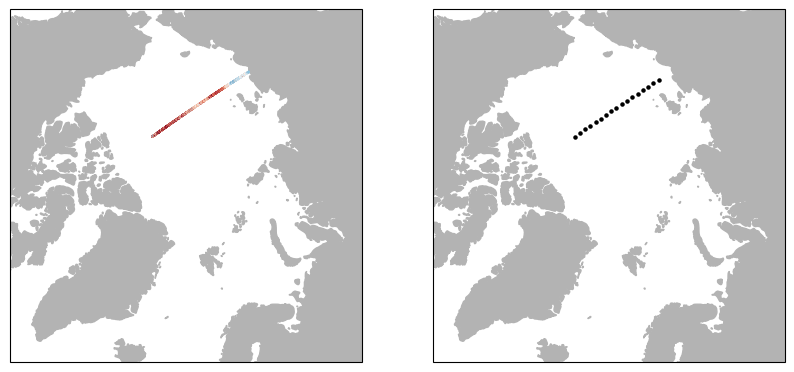

,x,y,t,lon,lat,date,class,interpSLA,elevation,SAT,track,dist_along_track
3051,-546016.208513,7.870765e+05,17907,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.000000e+00
3265,-463933.092598,8.457381e+05,17907,-151.252849,81.354797,20190111,floe,0.1058,0.1921,S3A,1,9.994286e+04
3492,-381627.223432,9.040727e+05,17907,-157.114416,81.204893,20190111,floe,0.1514,0.2990,S3A,1,1.998845e+05
3690,-299105.371262,9.620754e+05,17907,-162.729741,80.969739,20190111,floe,0.1631,0.1433,S3A,1,2.998243e+05
3825,-216099.960293,1.019932e+06,17907,-168.037266,80.654613,20190111,floe,0.1428,0.2485,S3A,1,4.000924e+05
3990,-133165.724552,1.077256e+06,17907,-172.953091,80.269255,20190111,floe,0.1102,0.2677,S3A,1,5.000264e+05
4192,-49760.137359,1.134422e+06,17907,-177.488394,79.819258,20190111,floe,0.0774,0.2515,S3A,1,6.002874e+05
4381,33283.280733,1.190861e+06,17907,178.399061,79.317314,20190111,floe,0.0529,-0.2437,S3A,1,6.998821e+05
4565,116230.866694,1.246762e+06,17907,174.673926,78.769895,20190111,floe,0.0425,0.1048,S3A,1,7.991409e+05
4655,201015.684995,1.303415e+06,17907,171.232783,78.169840,20190111,lead,0.0350,0.0139,S3A,1,9.003789e+05


In [14]:
#divide track into 200 km points for expert locations
Xs = np.array([df_val['lon'],df_val['lat']]).T
r_exp = GCdist(Xs,Xs) #compute distance matrix
df_val['dist_along_track'] = r_exp[0,:]
exp_grid = np.arange(0,np.sum(r_exp[0,:]),100e3)
locs = []
for ix in exp_grid:
    temp = np.abs(r_exp[0,:]-ix)
    dm = np.where(temp==np.min(temp))
    if len(locs)<=16:
        locs.append(dm[0][0])

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-180,180,65,90],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
    if c == 0:
        ax[c].scatter(df_val['lon'],df_val['lat'],c=df_val['elevation'],s=0.5,cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(df_val['lon'].iloc[locs],df_val['lat'].iloc[locs],s=5,c='k',transform=ccrs.PlateCarree())
plt.show()

experts = df_val.iloc[locs]
experts

# Interpolate along-track using GPSat

In [15]:
#WHERE TO SAVE

store_path = get_parent_path("/content/drive/MyDrive/GEOL0069/Week 8/GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5")

#if exists, remove before reprocessing
if os.path.exists(store_path):
    print(f"Removing removing old file: {store_path}")
    os.remove(store_path)

#SET PARAMETERS OF MODEL (e.g., use data within 300 km and +/- 4 days)
data = {
    "data_source": df.loc[(df['class']=='lead') & (np.abs(df['elevation'])<0.6) & (~np.isnan(df['elevation']))],
    "obs_col": "elevation",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<=",
            "val": 100_000
        },
        {
            "col": "t",
            "comp":"<=",
            "val":2
        },
        {
            "col": "t",
            "comp":">=",
            "val":-2
        }
    ],
    "global_select": [
        {
            "col": "lat",
            "comp": ">=",
            "val": 45
        }
    ]
}

#GIVE DATAFRAME OF EXPERTS
local_expert = {
    "source": experts
}

#GIVE DATAFRAME OF PREDICTION LOCATIONS (predict at all lead and floe locations along track)
pred_loc = {
    "method": "from_dataframe",
    "df": df_val,
    "max_dist": 200_000
}


#SETUP SPARSE GP MODEL (PLAY WITH MINIBATCH AND INDUCING POINTS)
model = {
    # "oi_model": "GPflowSVGPModel",
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [10000, 10000, 1],
        "minibatch_size": 100,
        "num_inducing_points":200
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [100_000, 100_000, 1e-08],
            # "low": [5_000, 5_000, 1e-08],
            "high": [200000, 200000, 4]
            },
            "likelihood_variance": {
                "low": 0.01,
                "high": 10
        }
    }
}

locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

#SMOOTH HYPERPARMETERS
smooth_configs = {"lengthscales": dict(l_x=200_000, l_y=200_000, max=12),
                  "likelihood_variance": dict(l_x=200_000, l_y=200_000),
                  "kernel_variance": dict(l_x=200_000, l_y=200_000, max=0.1)}

smooth_hyperparameters(result_file=store_path,
                       params_to_smooth=["lengthscales", "kernel_variance", "likelihood_variance"],
                       smooth_config_dict=smooth_configs,
                       save_config_file=False)

# %%
# ---
# Make predictions with smoothed hyperparameters
# ---
model['load_params'] = {"file": store_path, "table_suffix": "_SMOOTHED"}
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

locexp.run(store_path=store_path,
           optimise=False,
           predict=True,
           table_suffix='_SMOOTHED')

os.system('ptrepack --chunkshape=auto --propindexes --complib=blosc '+store_path+' temp_store_3D.csv')
os.system('rm '+store_path)
os.system('mv temp_store_3D.csv '+store_path)

print('Done!')

Removing removing old file: /content/drive/MyDrive/GEOL0069/Week 8/GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5
'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 180430 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 3008 >  100
storing as str
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object



/usr/local/lib/python3.11/dist-packages/tables/path.py:146: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 17
current local expert:
                  x              y      t         lon        lat      date  \
3051 -546016.208513  787076.451694  17907 -145.249909  81.414978  20190111   

     class  interpSLA  elevation  SAT  track  dist_along_track  
3051  floe        NaN     0.0247  S3A      1               0.0  
'data_select': 0.132 seconds
'load': 0.133 seconds
'local_data_select': 0.093 seconds
number obs: 368
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 5.544 seconds
'get_parameters': 0.026 seconds
'set_lengthscales_constraints': 0.045 seconds
'set_likelihood_variance_constraints': 0.139 seconds
'optimise_parameters': 7.488 seconds
'get_parameters': 0.012 seconds
parameters:
lengthscales: array([20., 20.,  4.]) 
kernel_variance: 0.001621677113709044
likelih

/usr/local/lib/python3.11/dist-packages/tables/path.py:146: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


'__init__': 0.040 seconds
'get_parameters': 0.008 seconds
'_read_params_from_file': 0.094 seconds
'set_parameters': 0.011 seconds
'set_lengthscales_constraints': 0.013 seconds
'set_likelihood_variance_constraints': 0.032 seconds
*** not optimising parameters
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([11.47250301, 11.99997765,  3.99      ]) 
kernel_variance: 0.003983122744023509
likelihood_variance: 0.01999999999999999
'predict': 0.084 seconds
total run time : 0.77 seconds
--------------------------------------------------
2 / 17
current local expert:
                  x              y      t         lon        lat      date  \
3265 -463933.092598  845738.103282  17907 -151.252849  81.354797  20190111   

     class  interpSLA  elevation  SAT  track  dist_along_track  
3265  floe     0.1058     0.1921  S3A      1      99942.861425  
'local_data_select': 0.051 seconds
number obs: 318
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.044 seconds
'_read_para

In [16]:
# extract, store in dict
store_path = "/content/drive/MyDrive/GEOL0069/Week 8/GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5"
dfs, _ = GPSat.local_experts.get_results_from_h5file(store_path)

reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
table: 'oi_config_SMOOTHED' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations


In [17]:
from GPSat.postprocessing import glue_local_predictions

In [18]:
preds_data = dfs["preds_SMOOTHED"]

preds_data.head()

,x,y,t,_dim_0,f*,f*_var,y_var,f_bar,pred_loc_x,pred_loc_y,pred_loc_t,lon,lat,date,class,interpSLA,elevation,SAT,track,dist_along_track
0,-546016.208513,787076.451694,17907.0,0,0.043424,0.000293,0.020293,0,-546016.208513,787076.451694,17907.0,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.0
1,-546016.208513,787076.451694,17907.0,1,0.043422,0.000293,0.020293,0,-545744.788692,787271.231607,17907.0,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.0
2,-546016.208513,787076.451694,17907.0,2,0.043421,0.000293,0.020293,0,-545473.353742,787466.002222,17907.0,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.0
3,-546016.208513,787076.451694,17907.0,3,0.043423,0.000293,0.020293,0,-545201.932777,787660.770465,17907.0,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.0
4,-546016.208513,787076.451694,17907.0,4,0.043425,0.000293,0.020293,0,-544930.498775,787855.541507,17907.0,-145.249909,81.414978,20190111,floe,NaN,0.0247,S3A,1,0.0


In [19]:
# # multiple local experts may make predictions at the same prediction location (pred_loc).
# # - for each prediction at a given location, take we weighted combination
# # - weights being a function of the distance to each local expert that made a prediction at a given location.

inference_radius = 200_000  # 200km
plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)



In [20]:
plt_data

,pred_loc_x,pred_loc_y,f*,f*_var
0,-546016.208513,7.870765e+05,0.042205,0.000420
1,-545744.788692,7.872712e+05,0.042223,0.000419
2,-545473.353742,7.874660e+05,0.042242,0.000418
3,-545201.932777,7.876608e+05,0.042263,0.000417
4,-544930.498775,7.878555e+05,0.042285,0.000416
...,...,...,...,...
2977,955257.667849,1.786233e+06,0.013022,0.005618
2978,955539.129893,1.786406e+06,0.013018,0.005634
2979,955820.569170,1.786580e+06,0.013014,0.005650
2980,956664.886400,1.787099e+06,0.013000,0.005697


In [21]:
#merge the two datasets containing SLA predictions and additional variables of interest
sla_df = pd.merge(df_val[['lon', 'lat', 'x', 'y', 'interpSLA', 'dist_along_track', 'class', 'elevation']], plt_data[['pred_loc_x', 'pred_loc_y', 'f*']], left_on=['x', 'y'], right_on=['pred_loc_x', 'pred_loc_y'])
sla_df['sla_diff'] = sla_df['interpSLA']-sla_df['f*']
sla_df

,lon,lat,x,y,interpSLA,dist_along_track,class,elevation,pred_loc_x,pred_loc_y,f*,sla_diff
0,-145.249909,81.414978,-546016.208513,7.870765e+05,NaN,0.000000e+00,floe,0.0247,-546016.208513,7.870765e+05,0.042205,NaN
1,-145.269889,81.414930,-545744.788692,7.872712e+05,NaN,3.309358e+02,floe,0.1204,-545744.788692,7.872712e+05,0.042223,NaN
2,-145.289868,81.414880,-545473.353742,7.874660e+05,NaN,6.618785e+02,floe,0.2833,-545473.353742,7.874660e+05,0.042242,NaN
3,-145.309847,81.414830,-545201.932777,7.876608e+05,NaN,9.928085e+02,floe,0.2403,-545201.932777,7.876608e+05,0.042263,NaN
4,-145.329826,81.414779,-544930.498775,7.878555e+05,NaN,1.323751e+03,floe,0.1529,-544930.498775,7.878555e+05,0.042285,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2977,151.862624,71.781861,955257.667849,1.786233e+06,-0.0407,1.792640e+06,lead,-0.0409,955257.667849,1.786233e+06,0.013022,-0.053722
2978,151.857915,71.779270,955539.129893,1.786406e+06,-0.0408,1.792970e+06,lead,-0.0611,955539.129893,1.786406e+06,0.013018,-0.053818
2979,151.853207,71.776679,955820.569170,1.786580e+06,-0.0410,1.793301e+06,lead,-0.0716,955820.569170,1.786580e+06,0.013014,-0.054014
2980,151.839091,71.768906,956664.886400,1.787099e+06,-0.0413,1.794292e+06,lead,-0.0373,956664.886400,1.787099e+06,0.013000,-0.054300


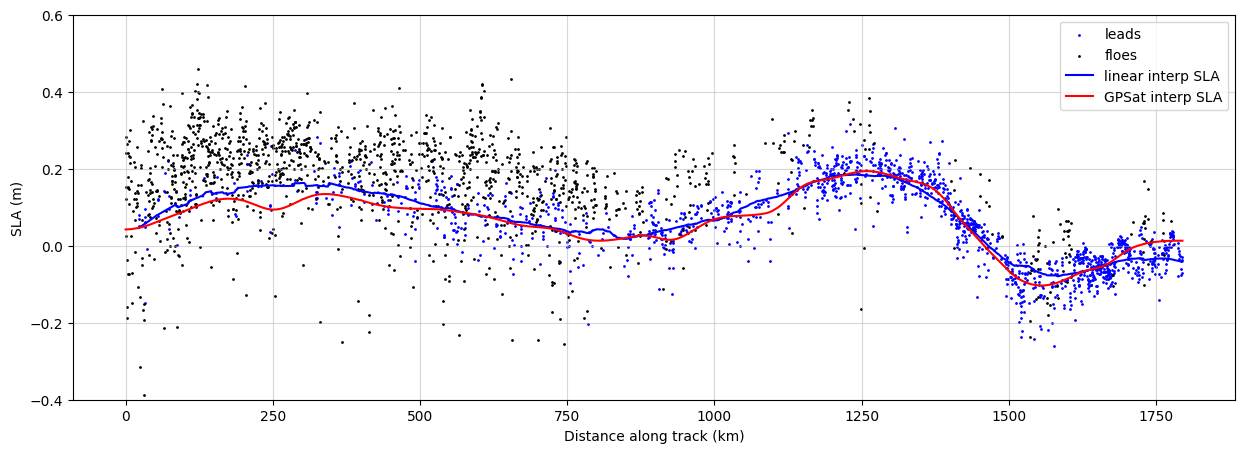

In [22]:
leads_df = sla_df[sla_df['class'] == 'lead']
floes_df = sla_df[sla_df['class'] == 'floe']

fig,ax = plt.subplots(1,figsize=(15,5))
ax.grid(True, alpha=0.5)
ax.scatter(leads_df['dist_along_track']/1000,leads_df['elevation'],color='b',s=1,label='leads')
ax.scatter(floes_df['dist_along_track']/1000,floes_df['elevation'],color='k',s=1,label='floes')
ax.plot(sla_df['dist_along_track']/1000,sla_df['interpSLA'],color='b',label='linear interp SLA')
ax.plot(sla_df['dist_along_track']/1000,sla_df['f*'],color='r',label='GPSat interp SLA')
ax.set_ylim(-0.4,0.6)
ax.set_ylabel('SLA (m)')
ax.set_xlabel('Distance along track (km)')
ax.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


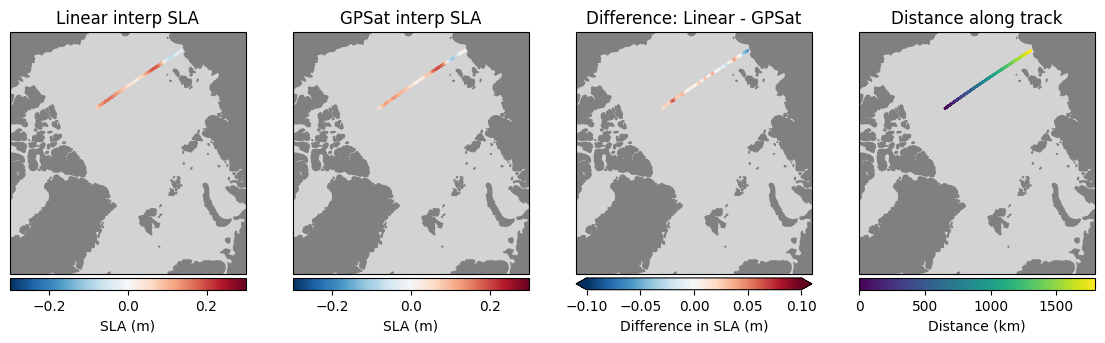

In [23]:
# Map the linear SLA, GPsat SLA and the difference
fig, axs = plt.subplots(1,4,figsize=(14,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
axs[0].set_extent([-180,180,71,90],ccrs.PlateCarree())
axs[0].add_feature(cfeat.OCEAN, color='lightgrey')
axs[0].add_feature(cfeat.LAND, color='grey')
lin_sla=axs[0].scatter(sla_df['lon'],sla_df['lat'],s=0.5,c=sla_df['interpSLA'],cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
axs[0].set_title('Linear interp SLA')
fig.colorbar(lin_sla,ax=axs[0], label='SLA (m)', orientation='horizontal', pad=0.01)

axs[1].set_extent([-180,180,71,90],ccrs.PlateCarree())
axs[1].add_feature(cfeat.OCEAN, color='lightgrey')
axs[1].add_feature(cfeat.LAND, color='grey')
gp_sla = axs[1].scatter(sla_df['lon'],sla_df['lat'],s=0.5,c=sla_df['f*'],cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
axs[1].set_title('GPSat interp SLA')
fig.colorbar(gp_sla, ax=axs[1], label='SLA (m)', orientation='horizontal', pad=0.01)

axs[2].set_extent([-180,180,71,90],ccrs.PlateCarree())
axs[2].add_feature(cfeat.OCEAN, color='lightgrey')
axs[2].add_feature(cfeat.LAND, color='grey')
sla_diff = axs[2].scatter(sla_df['lon'],sla_df['lat'],s=0.5,c=sla_df['sla_diff'],cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
axs[2].set_title('Difference: Linear - GPSat')
fig.colorbar(sla_diff,ax=axs[2], label='Difference in SLA (m)', orientation='horizontal', pad=0.01, extend='both')

axs[3].set_extent([-180,180,71,90],ccrs.PlateCarree())
axs[3].add_feature(cfeat.OCEAN, color='lightgrey')
axs[3].add_feature(cfeat.LAND, color='grey')
distot = axs[3].scatter(sla_df['lon'],sla_df['lat'],s=0.5, c=sla_df['dist_along_track']/1000, cmap='viridis', transform=ccrs.PlateCarree())
axs[3].set_title('Distance along track')
fig.colorbar(distot,ax=axs[3], label='Distance (km)', orientation='horizontal', pad=0.01)

plt.show()


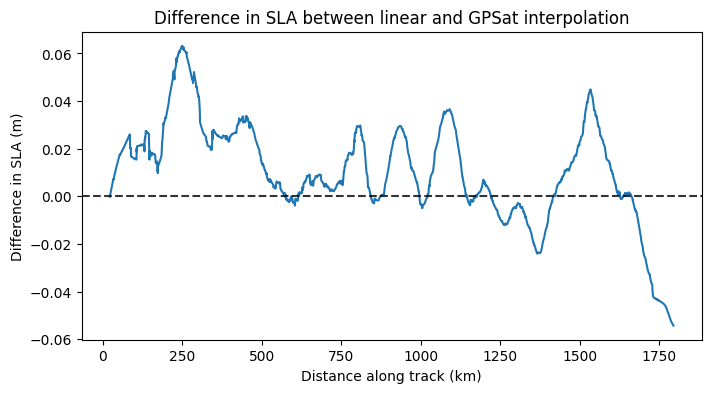

In [24]:
# Plot the difference in SLA
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(sla_df['dist_along_track']/1000, sla_df['sla_diff'])
ax.axhline(y=0, color='k', linestyle='--', alpha=0.8)
ax.set_xlabel('Distance along track (km)')
ax.set_ylabel('Difference in SLA (m)')
ax.set_title('Difference in SLA between linear and GPSat interpolation')
plt.show()